<a href="https://colab.research.google.com/github/FilippoAiraldi/RL-demos/blob/main/sailor_gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sailor Gridworld

Exercise 2 from ELEC-E8125 Reinforcement Learning.


## 0. Definitions

The sailor state is the position in the gridworld $$s = (x, y)$$
and there are five available actions
$$left, right, up, down, stay$$
When the sailor reaches the harbour, the episode terminates and a reward of 10 is given. If the sailor hits the rocks, the episode terminates and a reward of -2 is given. Otherwise, the reward is zero.

The shortest way to the harbour goes through a narrow passage between rocks, which is known to have unpredictable heavy wind conditions. When moving in that area, the sailor can be carried an extra "square" in a random direction - that is, land in any of the squares adjacent to the desired target
square. 
The sea around the passage is generally calm, but there's a low probability that the sailor will be carried in the direction perpendicular to where he was heading.
All of these probabilities ($p_{pcalm}$ and $p_{wind}$) as well as the exact location of the harbour are perfectly known to the sailor.

In [1]:
import gym
import numpy as np
import itertools

from tqdm.notebook import tqdm

from typing import List, Tuple, Dict

## 1. Implementation

In [2]:
CALM_SEA = 0
WINDY_SEA = 1
ROCK = 2
HARBOUR = 3

MAP = np.asarray([
    [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 3],
    [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

LEFT, RIGHT, UP, DOWN, STAY = range(5)
action2move = {
    LEFT:  ( 0, -1), 
    RIGHT: ( 0,  1), 
    UP:    (-1,  0), 
    DOWN:  ( 1,  0), 
    STAY:  ( 0,  0)  
}

action2txt = {
    LEFT:  '←',
    RIGHT: '→', 
    UP:    '↑', 
    DOWN:  '↓', 
    STAY:  'o'  
}

add2d = lambda a, b: (a[0] + b[0], a[1] + b[1])
add2d_and_clip = lambda a, b:  tuple(np.clip(add2d(a, b), (0, 0), (MAP.shape[0] - 1, MAP.shape[1] - 1)))

In [3]:
class SailorGridworld(gym.Env):
    def __init__(self, rock_penalty: float = -2.0, harbour_reward: float = 10.0, p_wind: float = 0.4, p_calm: float = 0.1) -> None:
        self.rock_penalty = rock_penalty
        self.harbour_reward = harbour_reward
        self.p_wind = p_wind
        self.p_calm = p_calm

        self.action_space = gym.spaces.Discrete(len(action2move))
        self.observation_space = gym.spaces.MultiDiscrete(MAP.shape)
        self.seed()
        self.reset()

    def seed(self, seed = None) -> List[int]:
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, state: Tuple[int,int] = None) -> Tuple[int, int]:
        self.state = state if state else (0, 0)
        return self.state

    @property
    def state(self) -> Tuple[int, int]:
        return self._state

    @state.setter
    def state(self, val: Tuple[int, int]) -> None:
        assert self.observation_space.contains(np.asarray(val)), f'invalid state {val} - not contained'
        assert MAP[val] != ROCK, f'invalid state {val} - rock'
        self._state = val

    def step(self, action: int) -> Tuple[Tuple[int, int], int, bool, Dict]:
        assert self.action_space.contains(action), f'invalid action {action}'
        tile = MAP[self.state]

        # check harbour-stay
        if tile == HARBOUR and action == STAY:
            return self.state, self.harbour_reward, True, {}

        # compute move and wind
        move = action2move[action]
        if tile == WINDY_SEA:
            # add additional movement
            if self.np_random.random() < self.p_wind:
                additional_move = action2move[self.np_random.choice([LEFT, RIGHT, UP, DOWN])]
                move = add2d(move, additional_move)
        elif tile == CALM_SEA:
            # overwrite movement
            if self.np_random.random() < self.p_calm:
                if action == UP or action == DOWN:
                    move = action2move[self.np_random.choice([LEFT, RIGHT])]
                elif action == LEFT or action == RIGHT:
                    move = action2move[self.np_random.choice([UP, DOWN])]
                # if stay, do nothing

        # make move and check out-of-bounds
        next_state = add2d_and_clip(self.state, move)
        next_tile = MAP[next_state]
        
        # check rocks
        if next_tile == ROCK:
            self._state = next_state
            return next_state, self.rock_penalty, True, {}
        self.state = next_state
        return next_state, 0, False, {}

### Utils

In [4]:
def one_step_lookahead(env: SailorGridworld, s: Tuple[int, int], V: np.ndarray, gamma: float) -> np.ndarray:
    get_reward = lambda s: env.rock_penalty if MAP[s] == ROCK else 0.0
    A = np.zeros(env.action_space.n)
    tile = MAP[s]
    if tile == HARBOUR:
        A[STAY] += 1.0 * (env.harbour_reward + gamma * V[s])
        for a in (UP, DOWN, LEFT, RIGHT):
            s_next = add2d_and_clip(s, action2move[a])
            A[a] += 1.0 * (get_reward(s_next) + gamma * V[s_next])
    elif tile == ROCK:
        for a in (UP, DOWN, LEFT, RIGHT):
            A[a] += 1.0 * (env.rock_penalty + gamma * V[s])
    elif tile == CALM_SEA:
        A[STAY] += 1.0 * (0.0 + gamma * V[s])
        for a in (UP, DOWN):
            s_next = add2d_and_clip(s, action2move[a])
            A[a] += (1 - env.p_calm) * (get_reward(s_next) + gamma * V[s_next])
            for a_perp in (LEFT, RIGHT):
                s_next = add2d_and_clip(s, action2move[a_perp])
                A[a] += (env.p_calm / 2) * (get_reward(s_next) + gamma * V[s_next])
        for a in (LEFT, RIGHT):
            s_next = add2d_and_clip(s, action2move[a])
            A[a] += (1 - env.p_calm) * (get_reward(s_next) + gamma * V[s_next])
            for a_perp in (UP, DOWN):
                s_next = add2d_and_clip(s, action2move[a_perp])
                A[a] += (env.p_calm / 2) * (get_reward(s_next) + gamma * V[s_next])
    elif tile == WINDY_SEA:
        for a in range(env.action_space.n):
            s_next = add2d_and_clip(s, action2move[a])
            A[a] += (1 - env.p_wind) * (get_reward(s_next) + gamma * V[s_next])
            for a_wind in (UP, DOWN, LEFT, RIGHT):
                s_wind = add2d_and_clip(s_next, action2move[a_wind])
                A[a] += (env.p_wind / 4) * (get_reward(s_wind) + gamma * V[s_wind])
    else:
        raise NotImplementedError(f'invalid tile type {tile}')
    return A

def get_policy(env: SailorGridworld, V: np.ndarray, gamma: float) -> np.ndarray:
    policy = np.empty(env.observation_space.nvec, dtype=np.uint16)
    for s in itertools.product(*[range(n) for n in env.observation_space.nvec]):
        A = one_step_lookahead(env, s, V, gamma)
        policy[s] = A.argmax()
    return policy

### Visualization

In [5]:
import matplotlib.pyplot as plt

def do_all_plots(env, gamma, V, policy, deltas, title = None, s0 = None) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7))
    if title: fig.suptitle(title)
    ax1.set_title('values and policy')
    im = ax1.imshow(V, cmap = 'hot')
    fig.colorbar(im, ax=ax1)
    # plot policy
    L = 0.5
    for x, y in itertools.product(*[range(n) for n in env.observation_space.nvec]):
        a = policy[x, y]
        if a == STAY:
            ax1.plot(y, x, 'ko')
        else:
            dx, dy = action2move[a]
            ax1.arrow(y - 0.25 * dy, x - 0.25 * dx, 0.5 * dy, 0.5 * dx, head_width = 0.125)
    # plot optimal path
    if s0:
        s = s0
        for _ in range(50):
            a = policy[s]
            dx, dy = action2move[a]
            ax1.arrow(s[1] - 0.25 * dy, s[0] - 0.25 * dx, 0.5 * dy, 0.5 * dx, head_width = 0.125, color='g')
            s = add2d_and_clip(s, (dx, dy))
            if MAP[s] == HARBOUR: break
    # plot convergence
    ax1.set_title('convergence')
    ax2.semilogy(deltas)
    ax2.grid(True)

## 2. Value Iteration

In [6]:
def value_iteration(env: SailorGridworld, gamma: float = 0.9, error_threshold: float = 1e-4) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    deltas = []
    V = np.zeros(env.observation_space.nvec, dtype=np.float64)
    states = list(itertools.product(*[range(n) for n in env.observation_space.nvec]))
    while True:
        delta = 0
        for s in states:
            best_action_value = np.max(one_step_lookahead(env, s, V, gamma))
            delta = max(delta, np.abs(best_action_value - V[s]))
            V[s] = best_action_value        
        deltas.append(delta)
        if delta < error_threshold:
            break
    return V, get_policy(env, V, gamma), deltas

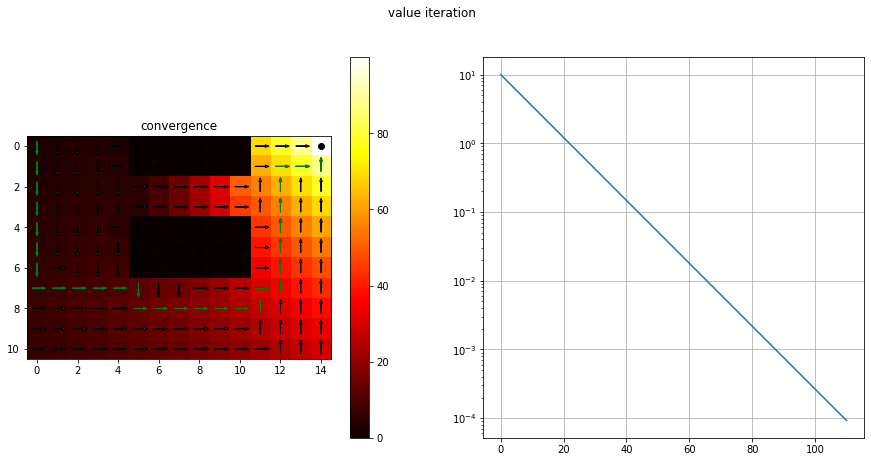

In [7]:
env = SailorGridworld(rock_penalty=-10, p_wind=0.75)
gamma = 0.9
V, policy, deltas = value_iteration(env, gamma=gamma)
do_all_plots(env, gamma, V, policy, deltas, title='value iteration', s0=(0, 0))

## 3. Policy Iteration

In [8]:
def policy_iteration(env: SailorGridworld, gamma: float = 0.9, error_threshold: float = 1e-4) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    deltas = []
    V = np.zeros(env.observation_space.nvec, dtype=np.float64)
    policy = np.random.randint(low=0, high=env.action_space.n, size=env.observation_space.nvec)
    states = list(itertools.product(*[range(n) for n in env.observation_space.nvec]))

    while True:
        # policy evaluation
        while True:
            delta = 0
            for s in states:
                v = V[s]
                V[s] = one_step_lookahead(env, s, V, gamma)[policy[s]]
                delta = max(delta, np.abs(v - V[s]))
            deltas.append(delta)
            if delta < error_threshold:
                break        

        # policy improvement
        policy_stable = True
        for s in states:
            old_action = policy[s]
            policy[s] = one_step_lookahead(env, s, V, gamma).argmax()
            if old_action != policy[s]: 
                policy_stable = False

        if policy_stable: 
            return V, policy, deltas

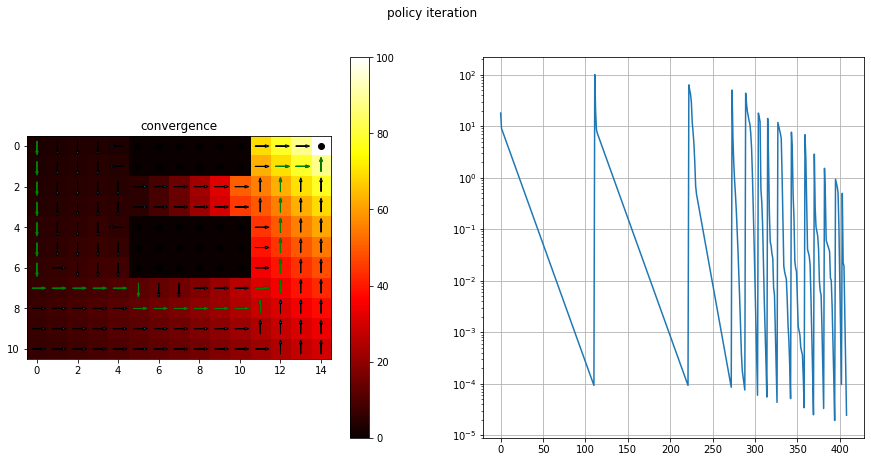

In [9]:
env = SailorGridworld(rock_penalty=-10, p_wind=0.75)
gamma = 0.9
V, policy, deltas = policy_iteration(env, gamma=gamma)
do_all_plots(env, gamma, V, policy, deltas, title='policy iteration', s0=(0, 0))